# Predicting the alpha signal.

# Approach to the problem:
     They is a Hedge Fund Manager. Manager want to invest Some amount in Stock Market Sector.By using the alpha value he was Selecting the Stock.Manager Collected Microblogging data for sentiment from the Social Media platform called ‘StockTwits’. 
     My Target is is to builda sentiment analysis model using the tagged data. This sentiment analysis model should then be used to generate a new stock factor which together with the other stock factors should be used to predict the Alpha Signal. 
     
     Target Variable:
     Alpha
     
     Type of Problem:
     Multiclass

In [1]:
# General
import pandas as pd
import numpy as np
import scipy
import re
import random
import os

# Visualization
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from bs4 import BeautifulSoup


# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore') 
import PIL.Image
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# modules for generating the word cloud
from os import path, getcwd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from IPython.display import Image
from PIL import Image
from nltk.stem import PorterStemmer, LancasterStemmer

#Bag of words
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from collections import Counter as cn

# Importing the train json

In [2]:
import json
from pandas.io.json import json_normalize
with open('train_data-PHD.json') as f:
    a=json.load(f)

In [3]:
data_json1= json_normalize(a['records'])

In [4]:
print(data_json1.shape)
data_json1.head()

(1039131, 4)


,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [5]:
data_json1.tail()

,sentiment_score,stocktwit_tweet,ticker,timestamp
1039126,2,$CLF https://twitter.com/hrdrckminer/status/10...,$CLF,2018-08-13 22:15:04+00:00
1039127,3,$AMD 🔥🔥🔥,$AMD,2018-09-04 15:25:59+00:00
1039128,0,$FB damn should of shorted 196 after hours to ...,$FB,2018-07-25 21:29:03+00:00
1039129,0,$AMD back to the 31&#39;s,$AMD,2018-09-28 16:19:55+00:00
1039130,2,$AMZN Lagging other tech today.,$AMZN,2018-07-05 17:14:00+00:00


In [6]:
#Checking for dtypes
data_json1.dtypes

sentiment_score     int64
stocktwit_tweet    object
ticker             object
timestamp          object
dtype: object

 Observations timestamp should divided into date and time and convert into dataetime format

In [7]:
#Converting  datetime object into datetime dtype
import datetime as date
data_json1['timestamp']=pd.to_datetime(data_json1['timestamp'],format='%Y-%m-%d %H:%M:%S')
data_json1.dtypes

sentiment_score                  int64
stocktwit_tweet                 object
ticker                          object
timestamp          datetime64[ns, UTC]
dtype: object

In [8]:
#Creating new columns for Date and Time
data_json1['time']=data_json1['timestamp'].apply(lambda x:x.time)
data_json1['date']=data_json1['timestamp'].apply(lambda x:x.date)

In [9]:
#Droping the timestamp column
data_json1.drop(['timestamp'],axis=1,inplace = True)

In [10]:
#Checking the Columns names
data_json1.columns

Index(['sentiment_score', 'stocktwit_tweet', 'ticker', 'time', 'date'], dtype='object')

In [11]:
# Create New Variables: 
# Word Length
data_json1["Word Count"] = data_json1['stocktwit_tweet'].str.split().apply(len)
# Character Length
data_json1["Character Count"] = data_json1['stocktwit_tweet'].apply(len)
# Boolean for Positive and Negative Reviews
data_json1["Label"] = 0
data_json1.loc[data_json1.sentiment_score >= 2,["Label"]] = 1

In [12]:
data_json1.head()

,sentiment_score,stocktwit_tweet,ticker,time,date,Word Count,Character Count,Label
0,3,$AMD going up but hesitating however chart is ...,$AMD,18:38:28,2018-09-19,13,74,1
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,03:51:06,2018-10-09,11,69,1
2,2,$AVGO WTF?,$AVGO,13:35:32,2018-07-12,2,10,1
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,03:32:50,2018-07-19,11,111,1
4,3,$FB if it bounces tommorrow do the right thing...,$FB,19:07:54,2018-08-23,11,55,1


In [13]:
# Missing Values
unique_count = []
for x in data_json1.columns:
    unique_count.append([x,len(data_json1[x].unique()),data_json1[x].isnull().sum()])

In [14]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*data_json1.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 1039131 Rows, 8 Columns


Column,sentiment_score,stocktwit_tweet,ticker,time,date,Word Count,Character Count,Label
Unique,5,959608,2181,82115,123,43,408,2
Missing,0,0,0,0,0,0,0,0


In [15]:
# Summary of the dataset
data_json1.describe().T.drop("count",axis = 1)

,mean,std,min,25%,50%,75%,max
sentiment_score,2.203079,1.105371,0.0,2.0,2.0,3.0,4.0
Word Count,12.235126,7.012862,1.0,6.0,11.0,17.0,66.0
Character Count,87.058554,61.958559,2.0,39.0,77.0,122.0,3085.0
Label,0.795220,0.403541,0.0,1.0,1.0,1.0,1.0


observations sentiment_score has 50% of 2's. On average 12 words are contain in tweet and 87 Character Count

In [16]:
data_json1[["stocktwit_tweet","ticker","time",'date']].describe(include=["O"]).T.drop("count",axis = 1)

,unique,top,freq
stocktwit_tweet,959608,$AMD,2474
ticker,2181,$AMD,163675
time,82115,14:00:03,840
date,123,2018-07-26,27063


observations AMD(Advanced Micro Devices) has More tweet.

In [17]:
#sentiment count
print('sentiment_score_frequency \n',data_json1['sentiment_score'].value_counts())
print('Label_frequency \n',data_json1['Label'].value_counts())

sentiment_score_frequency 
 2    464402
3    208031
4    153905
1    120771
0     92022
Name: sentiment_score, dtype: int64
Label_frequency 
 1    826338
0    212793
Name: Label, dtype: int64


### Row_plots for sentiment_score and Label

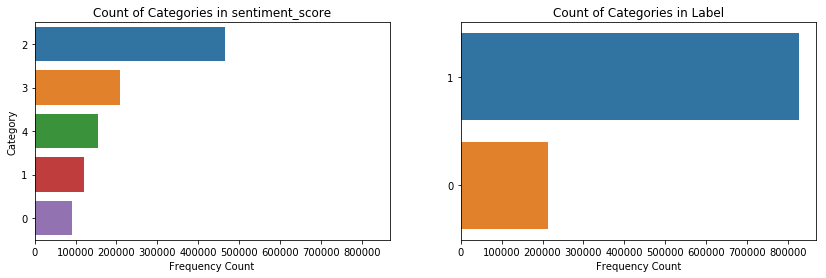

In [18]:
row_plots = ["sentiment_score","Label"]
f,axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=True)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=data_json1,order=data_json1[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

observations the total of Zeros's and Ons's is 2 Lakhs. And the total of 4,3,2 is more than eight Lakhs

### Distributions plots

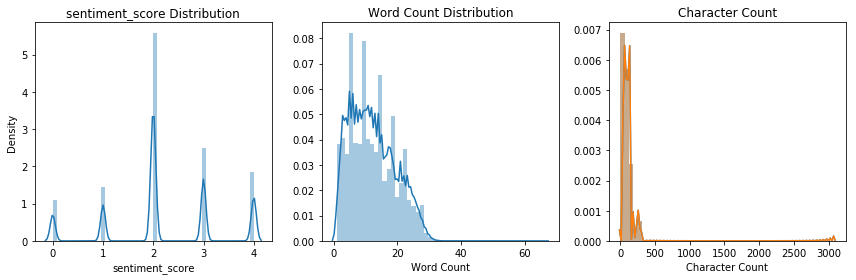

In [19]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(data_json1.sentiment_score, ax=ax[0])
ax[0].set_title("sentiment_score Distribution")
ax[0].set_ylabel("Density")
sns.distplot(data_json1["Word Count"], ax=ax[1])
ax[1].set_title("Word Count Distribution")
sns.distplot(data_json1["Character Count"], ax=ax[2])
ax[2].set_title("Character Count")
ax[2].set_xlabel("Character Count")
sns.distplot(data_json1["Character Count"], ax=ax[2])
plt.tight_layout()
plt.show()

Observations maximum words are 66 in a tweet and maximum CharacterCount3065

Distplot

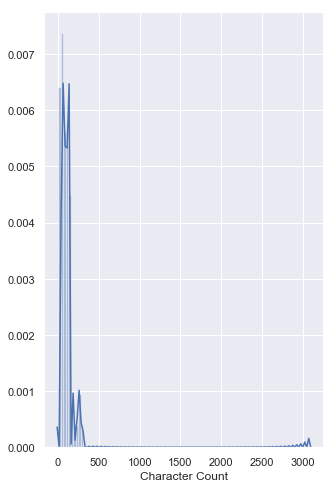

In [20]:
sns.set(rc={'figure.figsize':(5,8)})
sns.distplot(data_json1['Character Count'] ,hist=True, bins=100)

# Text normalization

In [22]:
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].replace('\#\w+', ' ',regex=True).astype(object)

In [23]:
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].replace('\@\w+', ' ',regex=True).astype(object)

In [24]:
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].replace('\$\w+', ' ',regex=True).astype(object)

In [25]:
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].replace('[^\w]', ' ',regex=True).astype(object)

In [26]:
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].replace('[\d]', ' ',regex=True).astype(object)

In [27]:
data_json1['stocktwit_tweet'] = data_json1['stocktwit_tweet'].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)

In [28]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [29]:
#Apply function on  stocktwit_tweet column
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].apply(strip_html)

In [30]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Apply function on  stocktwit_tweet column
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].apply(remove_between_square_brackets)

In [31]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on stocktwit_tweet column
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].apply(remove_special_characters)

In [32]:
#Define function for removing punctuation_removal
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str
data_json1['stocktwit_tweet'] = data_json1['stocktwit_tweet'].apply(punctuation_removal)
data_json1['stocktwit_tweet'].head()

0      going up but hesitating however chart is ver...
1           Despite China trade war   held very well  
2                                                 WTF 
3       New Insider Filing On    MULLER KLAUS PETER...
4      if it bounces tommorrow do the right thing a...
Name: stocktwit_tweet, dtype: object

In 2nd and 3rd columns They are some Spaces we can observe 

In [33]:
# Removing the columns
data_json1['stocktwit_tweet']=data_json1['stocktwit_tweet'].replace('\s+', ' ',regex=True).astype(object)

In [34]:
data_json1['stocktwit_tweet'].head(5)

0     going up but hesitating however chart is very...
1              Despite China trade war held very well 
2                                                 WTF 
3     New Insider Filing On MULLER KLAUS PETER Tran...
4     if it bounces tommorrow do the right thing an...
Name: stocktwit_tweet, dtype: object

In [35]:
# REMOVE NaN VALUES AND EMPTY STRINGS:
data_json1.dropna(inplace=True)

blanks = []  # start with an empty list

for a,b,c,d,e,f,g,h,i in data_json1.itertuples():  # iterate over the DataFrame
    if type(c)==str:            # avoid NaN values
        if c.isspace():         # test 'stocktwit_tweet' for whitespace
            blanks.append(a)     # add matching index numbers to the list

data_json1.drop(blanks, inplace=True)

In [37]:
len(blanks)

33360

In [38]:
data_json1.shape # Before 1039131 Rows, 8 Columns

(1005771, 8)

# Spacy stop_words

In [39]:
#Setting English stopwords
import spacy
stopword_list = spacy.load('en_core_web_sm')

In [40]:
# Print the set of spaCy's default stop words:
(stopword_list.Defaults.stop_words)

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [41]:
len(stopword_list.Defaults.stop_words)

326

In [45]:
n_rare_words = 2000
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remoreve the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])
RAREWORDS

{'Jpg',
 'Hhahahahajah',
 'HUNTER',
 'leggoooo',
 'Pennys',
 'babY',
 'petstore',
 'americaaaa',
 'Febr',
 'Ds',
 'Demos',
 'simpl',
 'wotking',
 'biktarvy',
 'CORNHOLE',
 'quoi',
 'shanung',
 'Quintero',
 'Ooooof',
 'selon',
 'WEekend',
 'slipity',
 'Gazelle',
 'FarmVille',
 'dopemglad',
 'smake',
 'DAAAAAAAMN',
 'NetFUCK',
 'bereiche',
 'Bwhahahaa',
 'Nutflex',
 'trustable',
 'AWith',
 'Panty',
 'Lking',
 'PRAYERS',
 'FAANgs',
 'Fenix',
 'holf',
 'sqeezing',
 'SHEETS',
 'supportish',
 'referrals',
 'hypovolemia',
 'delustional',
 'aaaamazzzing',
 'WCC',
 'tkmorro',
 'fututes',
 'smang',
 'mentos',
 'twosome',
 'ENBL',
 'munday',
 'collary',
 'AMDmoly',
 'Synchronized',
 'trrend',
 'FOx',
 'cpah',
 'Strugling',
 'HEDGES',
 'ecenomy',
 'GREESY',
 'accure',
 'Chiny',
 'Volga',
 'drivethru',
 'indeterminate',
 'mittelstand',
 'amunition',
 'Futres',
 'FeeBay',
 'Nebel',
 'qont',
 'assassins',
 'cloudier',
 'walj',
 'veey',
 'boed',
 'graders',
 'WILLLL',
 'monthsahead',
 'tremound',
 'DO

In [46]:
data_json1["stocktwit_tweet"] = data_json1["stocktwit_tweet"].apply(lambda text: remove_rarewords(text))

In [43]:
from collections import Counter
cnt = Counter()

In [44]:
for text in data_json1["stocktwit_tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(70000)

[('to', 243293),
 ('the', 239498),
 ('is', 182569),
 ('a', 170910),
 ('for', 168610),
 ('on', 149692),
 ('of', 133838),
 ('s', 129329),
 ('in', 129185),
 ('and', 127391),
 ('this', 122377),
 ('I', 109889),
 ('it', 103212),
 ('at', 92931),
 ('will', 75734),
 ('up', 69057),
 ('are', 58430),
 ('be', 57040),
 ('that', 56207),
 ('you', 54421),
 ('Q', 53233),
 ('t', 47494),
 ('down', 43611),
 ('from', 41370),
 ('with', 41143),
 ('just', 40746),
 ('today', 39997),
 ('not', 39692),
 ('short', 38599),
 ('out', 36964),
 ('what', 36573),
 ('was', 36118),
 ('we', 35017),
 ('buy', 34367),
 ('all', 34100),
 ('Estimize', 34070),
 ('by', 33781),
 ('now', 33391),
 ('have', 33315),
 ('more', 32078),
 ('like', 31919),
 ('here', 31783),
 ('but', 31354),
 ('going', 30862),
 ('my', 30666),
 ('stock', 29426),
 ('Reporting', 29106),
 ('if', 28992),
 ('back', 28280),
 ('day', 27502),
 ('they', 27039),
 ('go', 26848),
 ('has', 26635),
 ('see', 26438),
 ('can', 26304),
 ('quot', 26085),
 ('analysts', 25844),
 ('

They are some words which repets more times EPS,AMC,AMD,Apple,Amazon,Hold,Sell,Buying..... And they are some words are not required.In next step i will remove those unwanted words

# Removing stop words

In [47]:
len(stopword_list.Defaults.stop_words)

326

In [48]:
# Remove the word from the set of stop words
stopword_list.Defaults.stop_words.remove('above')

In [49]:
stopword_list.Defaults.stop_words.remove('up')

In [50]:
stopword_list.Defaults.stop_words.remove('down')

In [51]:
stopword_list.Defaults.stop_words.remove('call')

In [52]:
len(stopword_list.Defaults.stop_words)

322

These are some words which I feel it is required from stopword_list

# Adding stopwords

In [53]:
add_stopwords = list(set(stopword_list.Defaults.stop_words))

In [54]:
L=['b','T','P','a','s','I','Q','t','m','i','lol','its','A','po','u','gt','B','k','ve','th','F','P','LoL','AH','w','b','d','U','c','To','C','MA','PE','TO','im','GE','X','x','E','D','R','oh','Do','er','G','ya','r','n','y','H','FY','com','AND','AT','imo','As','J','ON']
for i in L :
    add_stopwords.append(i)

Adding some words to stopwords_list and then removing the Total stopwords

In [55]:
len(add_stopwords)

380

Removing the stopwords

In [56]:
def stopwords_removal(stop_str):
    stop_str = word_tokenize(stop_str)
    return " ".join([word.lower() for word in stop_str 
            if word.lower() not in add_stopwords])

In [57]:
data_json1['stocktwit_tweet'] = data_json1['stocktwit_tweet'].apply(stopwords_removal)
data_json1['stocktwit_tweet'].head()

0        going up hesitating chart stable going upward
1                         despite china trade war held
2                                                  wtf
3    new insider filing muller klaus peter transact...
4                   bounces tommorrow right thing gtfo
Name: stocktwit_tweet, dtype: object

# Bags of words

sentiment_score == 0

Text(0.5, 1.0, 'Top 25 trigrams for sentiment_0(negative_sentiment)')

<Figure size 864x864 with 0 Axes>

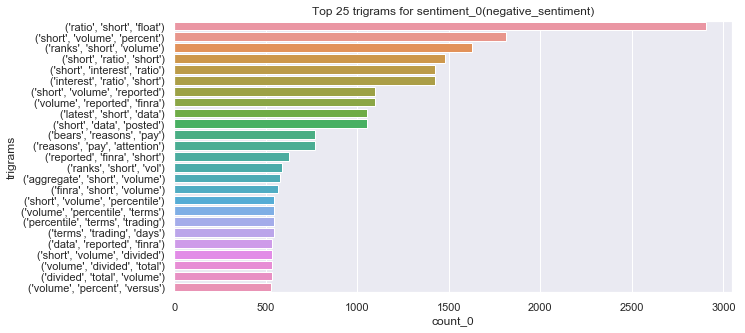

In [58]:
plt.figure(figsize=(12,12))
text = ' '.join(data_json1.loc[data_json1.sentiment_score == 0, 'stocktwit_tweet'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]
count_0=cn(text_trigrams).most_common(25)
dataframe=pd.DataFrame(count_0,columns=['trigrams','count_0'])
plt.figure(figsize=(10,5))
sns.barplot(x='count_0',y='trigrams',data=dataframe)
plt.title('Top 25 trigrams for sentiment_0(negative_sentiment)')

Observations
Of the 25 most frequent words across traders tweet in negative_sentiment is 'short volume percent','short interest ration','Divide total volume','bear reason pay'

sentiment_score == 1

Text(0.5, 1.0, 'Top 25 trigrams for sentiment_1')

<Figure size 864x864 with 0 Axes>

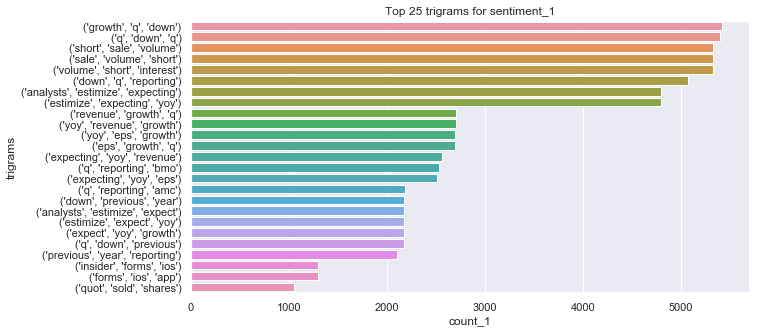

In [60]:
plt.figure(figsize=(12,12))
text = ' '.join(data_json1.loc[data_json1.sentiment_score == 1, 'stocktwit_tweet'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]
count_1=cn(text_trigrams).most_common(25)
dataframe=pd.DataFrame(count_1,columns=['trigrams','count_1'])
plt.figure(figsize=(10,5))
sns.barplot(x='count_1',y='trigrams',data=dataframe)
plt.title('Top 25 trigrams for sentiment_1')

Observations Of the 25 most frequent words across traders tweet_1 'down previous year','down q reporting','short sale volume','analyst estimize expecting'

sentiment_score == 2

Text(0.5, 1.0, 'Top 25 trigrams for sentiment_2')

<Figure size 864x864 with 0 Axes>

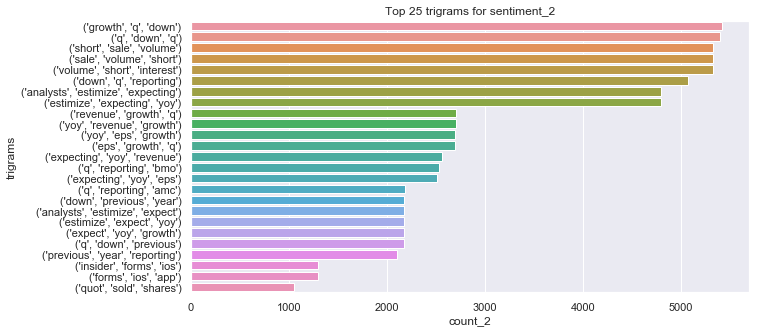

In [61]:
plt.figure(figsize=(12,12))
text = ' '.join(data_json1.loc[data_json1.sentiment_score == 2, 'stocktwit_tweet'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]
count_2=cn(text_trigrams).most_common(25)
dataframe=pd.DataFrame(count_1,columns=['trigrams','count_2'])
plt.figure(figsize=(10,5))
sns.barplot(x='count_2',y='trigrams',data=dataframe)
plt.title('Top 25 trigrams for sentiment_2')

Observations Of the 25 most frequent words across traders tweet_2 'yoy EPS growth','insider form io','revenue growth'

sentiment_score == 3

Text(0.5, 1.0, 'Top 25 trigrams for sentiment_3')

<Figure size 864x864 with 0 Axes>

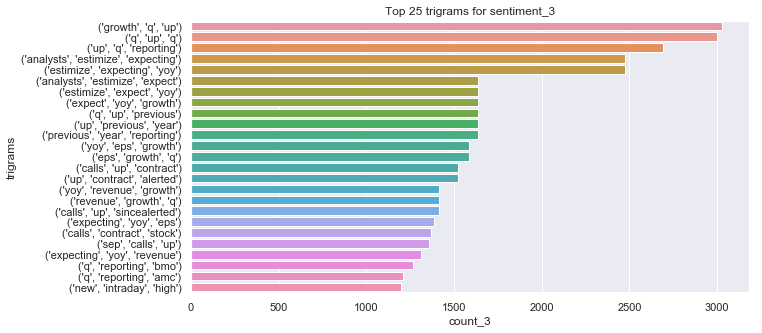

In [62]:
plt.figure(figsize=(12,12))
text = ' '.join(data_json1.loc[data_json1.sentiment_score == 3, 'stocktwit_tweet'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]
count_3=cn(text_trigrams).most_common(25)
dataframe=pd.DataFrame(count_3,columns=['trigrams','count_3'])
plt.figure(figsize=(10,5))
sns.barplot(x='count_3',y='trigrams',data=dataframe)
plt.title('Top 25 trigrams for sentiment_3')

sentiment_score == 4

Text(0.5, 1.0, 'Top 25 trigrams for sentiment_4(positive_sentiment)')

<Figure size 864x864 with 0 Axes>

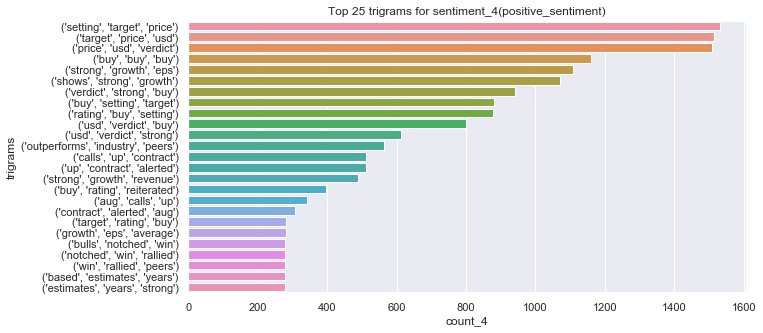

In [63]:
plt.figure(figsize=(12,12))
text = ' '.join(data_json1.loc[data_json1.sentiment_score == 4, 'stocktwit_tweet'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]
count_4=cn(text_trigrams).most_common(25)
dataframe=pd.DataFrame(count_4,columns=['trigrams','count_4'])
plt.figure(figsize=(10,5))
sns.barplot(x='count_4',y='trigrams',data=dataframe)
plt.title('Top 25 trigrams for sentiment_4(positive_sentiment)')

Observations Of the 25 most frequent words across traders tweet_4 'strong growth revenue','bulls notched win','buy rating reiterated','buy buy buy'

# lemmatizer

In [64]:
from nltk.stem import WordNetLemmatizer

In [65]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [66]:
data_json1["stocktwit_tweet"] = data_json1["stocktwit_tweet"].apply(lambda text: lemmatize_words(text))

In [67]:
data_json1["stocktwit_tweet"].head()

0        going up hesitating chart stable going upward
1                         despite china trade war held
2                                                  wtf
3    new insider filing muller klaus peter transact...
4                    bounce tommorrow right thing gtfo
Name: stocktwit_tweet, dtype: object

# Word cloud

In [68]:
pos_df = data_json1[data_json1.sentiment_score== 4]
aboveavg_df = data_json1[data_json1.sentiment_score== 3]
avg_df = data_json1[data_json1.sentiment_score== 2]
neg_df = data_json1[data_json1.sentiment_score== 1]
verybad_df = data_json1[data_json1.sentiment_score== 0]

In [69]:
pos_words =[]
aboveavg_words =[]
avg_words =[]
neg_words =[]
verybad_words =[]

for stocktwit_tweet in pos_df.stocktwit_tweet:
    pos_words.append(stocktwit_tweet) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for stocktwit_tweet in aboveavg_df.stocktwit_tweet:
    aboveavg_words.append(stocktwit_tweet) 
aboveavg_words = ' '.join(aboveavg_words)
aboveavg_words[:40]

for stocktwit_tweet in avg_df.stocktwit_tweet:
    avg_words.append(stocktwit_tweet)
avg_words = ' '.join(avg_words)
avg_words[:40]

for stocktwit_tweet in neg_df.stocktwit_tweet:
    neg_words.append(stocktwit_tweet) 
neg_words = ' '.join(neg_words)
neg_words[:40]

for stocktwit_tweet in verybad_df.stocktwit_tweet:
    verybad_words.append(stocktwit_tweet) 
verybad_words = ' '.join(verybad_words)
verybad_words[:400]

'usual red day mm took sl won bounce po short high easy flip astonishing crash nflx late year end hyper bubble best time leave minute opening tomorrow bull trap down market wrong po huge drop short ratio short float short volume percentile term trading day headed consolidation break wow short set up look like bouncing ball short floor easy short call bear hungry bacon pig fat friend eps up listen a'

In [70]:
from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

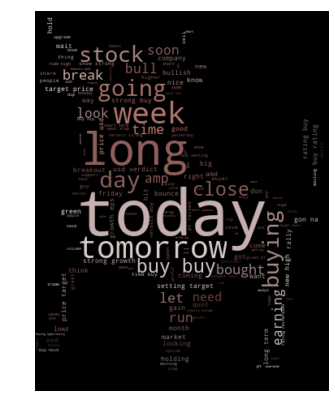

In [71]:
d = getcwd()
#join all documents in corpus
text = " ".join(pos_words)
mask = np.array(Image.open(path.join(d, "22.png")))
wc = WordCloud(background_color="black", max_words=len(pos_words), mask=mask,
               max_font_size=90, random_state=42)
wc.generate(pos_words)
#create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()

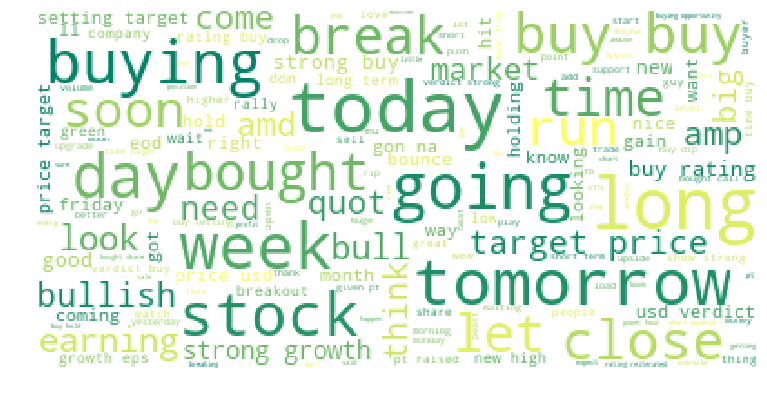

In [72]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

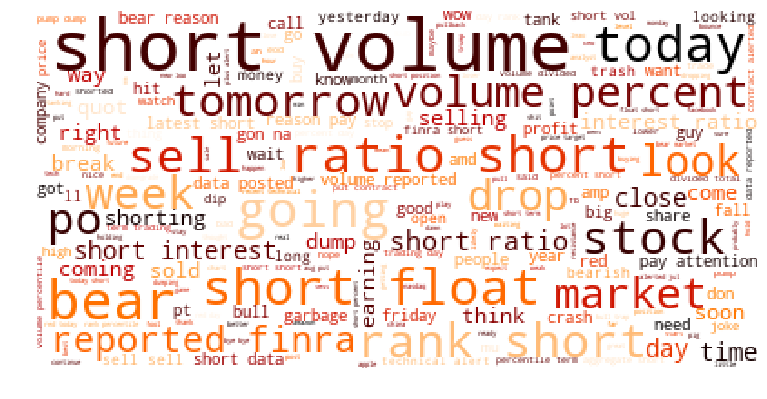

In [73]:
wordcloud = WordCloud().generate(verybad_words)

wordcloud = WordCloud(background_color="white",max_words=len(verybad_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(verybad_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Valence Aware Dictionary for Sentiment Reasoning(VADER)

In [74]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()
data_json1["stocktwit_tweet"]= data_json1["stocktwit_tweet"].astype(str)

# Applying Model, Variable Creation
data_json1['Polarity Score']=data_json1["stocktwit_tweet"].apply(lambda x:SIA.polarity_scores(x)['compound'])
data_json1['Neutral Score']=data_json1["stocktwit_tweet"].apply(lambda x:SIA.polarity_scores(x)['neu'])
data_json1['Negative Score']=data_json1["stocktwit_tweet"].apply(lambda x:SIA.polarity_scores(x)['neg'])
data_json1['Positive Score']=data_json1["stocktwit_tweet"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
data_json1['Sentiment']=''
data_json1.loc[data_json1['Polarity Score']>0,'Sentiment']='Positive'
data_json1.loc[data_json1['Polarity Score']==0,'Sentiment']='Neutral'
data_json1.loc[data_json1['Polarity Score']<0,'Sentiment']='Negative'

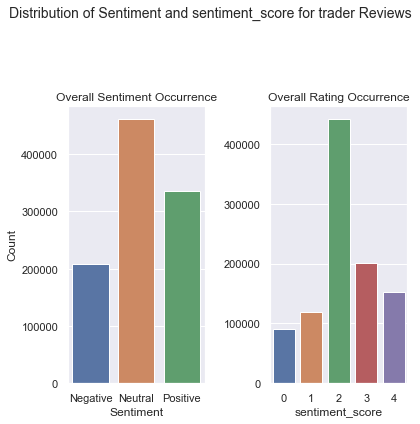

In [75]:
f, axes = plt.subplots(1,2,figsize=(6,6))
sns.countplot(x="Sentiment", data=data_json1, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
axes[0].set_title("Overall Sentiment Occurrence")

sns.countplot(x="sentiment_score", data=data_json1, ax=axes[1])
axes[1].set_xlabel("sentiment_score")
axes[1].set_ylabel("")
axes[1].set_title("Overall Rating Occurrence")

f.suptitle("Distribution of Sentiment and sentiment_score for trader Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.75)
plt.show()

# Train_Test_Split

In [76]:
X = data_json1['stocktwit_tweet']
y = data_json1['sentiment_score']

In [77]:
from sklearn.model_selection import train_test_split as split

In [78]:
trainx, valx, trainy, valy = split(X,y, test_size=0.3, stratify=y, random_state=123)
trainx.shape, valx.shape, trainy.shape, valy.shape

((704039,), (301732,), (704039,), (301732,))

# TF-IDF

In [79]:
#tf_idf_vectorizer = TfidfVectorizer()

In [80]:
#trainx.head()

In [81]:
#trainy.head()

In [82]:
# TF-IDF feature matrix
#TF_IDF_Train= tf_idf_vectorizer.fit_transform(trainx)

In [83]:
#TF_IDF_val = tf_idf_vectorizer.transform(valx)

In [84]:
#from sklearn.naive_bayes import MultinomialNB
#nb_clf = MultinomialNB().fit(TF_IDF_Train, trainy) #nb_clf is the classifier
#pred_train = nb_clf.predict(TF_IDF_Train) #get predictions on train data

In [85]:
#from sklearn.metrics import classification_report
#print(classification_report(trainy.astype('int'), pred_train))

In [86]:
#pred = nb_clf.predict(TF_IDF_val) #predict on test data
#print(classification_report(valy.astype('int'),pred))

# Count vectorizer

In [87]:
cv=CountVectorizer()

In [88]:
trainx.head()

1004110                tiny bit dry powder advantage dip mom
653512     bring yearly quarterly revision earnings cent ...
771674                                          hope got dip
609233                           usual overreaction tiresome
644787                   today expecting movement fall today
Name: stocktwit_tweet, dtype: object

In [89]:
trainy.head()

1004110    3
653512     4
771674     2
609233     2
644787     3
Name: sentiment_score, dtype: int64

In [90]:
cv_train = cv.fit_transform(trainx)

In [230]:
cv_train

<704039x61579 sparse matrix of type '<class 'numpy.int64'>'
	with 3959447 stored elements in Compressed Sparse Row format>

In [91]:
cv_val = cv.transform(valx)

In [231]:
cv_val

<301732x61579 sparse matrix of type '<class 'numpy.int64'>'
	with 1683573 stored elements in Compressed Sparse Row format>

Now text is compressed into sparse martix (vector format)

# Modelling on CountVectorizer data

Building logistic regression model for bag of words

In [92]:
#training the model
lr=LogisticRegression()
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train,trainy)
print(lr_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [93]:
#Predicting the model for bag of words on train
lr_bow_predict=lr.predict(cv_train)
print(lr_bow_predict)

[3 2 3 ... 2 2 2]


# Creating the indexes for the pred column

In [94]:
indexes = np.array(trainx.index)

In [95]:
train_pred_index = pd.DataFrame(lr_bow_predict,columns = ['pred'],index = indexes)

In [96]:
train_pred_index.head()

,pred
1004110,3
653512,2
771674,3
609233,2
644787,1


#  classification_report on Train json data

In [97]:
print(classification_report(trainy.astype('int'),lr_bow_predict))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61     63673
           1       0.65      0.45      0.53     83472
           2       0.69      0.89      0.78    309467
           3       0.61      0.41      0.49    140987
           4       0.68      0.63      0.65    106440

    accuracy                           0.67    704039
   macro avg       0.66      0.59      0.61    704039
weighted avg       0.67      0.67      0.66    704039



# Predicting on validation json data

In [98]:
pred_val = lr.predict(cv_val) #predict on test data
print(classification_report(valy.astype('int'),pred_val))

              precision    recall  f1-score   support

           0       0.65      0.53      0.58     27288
           1       0.60      0.41      0.49     35774
           2       0.67      0.88      0.76    132629
           3       0.56      0.37      0.45     60424
           4       0.65      0.60      0.63     45617

    accuracy                           0.65    301732
   macro avg       0.63      0.56      0.58    301732
weighted avg       0.64      0.65      0.63    301732



# Computing Actual and Predicted

Text(0, 0.5, 'sentiment_score')

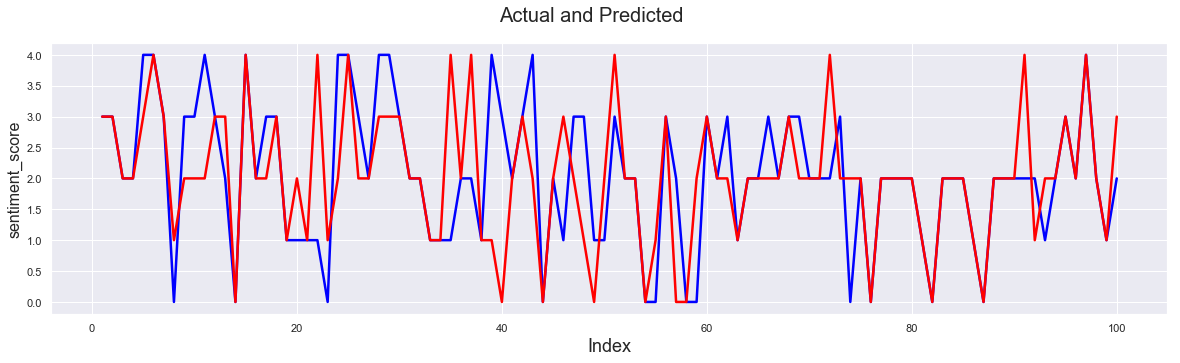

In [232]:
# Actual vs Predicted values for first 100000 rows
import matplotlib.pyplot as plt
c = [i for i in range(1,101,1)]         # generating index 
fig = plt.figure(figsize=(20,5))
plt.plot(c,valy.iloc[:100,], color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,pred_val[:100,], color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('sentiment_score', fontsize=16)                       # Y-label

Text(0, 0.5, 'y_val')

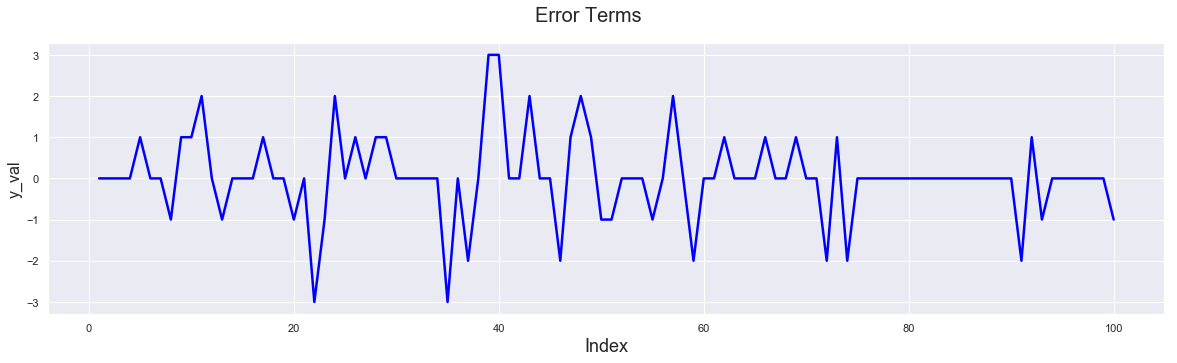

In [234]:
# Error terms
c = [i for i in range(1,101,1)]
fig = plt.figure(figsize=(20,5))
plt.plot(c,(valy[:100,]-pred_val[:100,]), color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('y_val', fontsize=16)                # Y-label

In [101]:
pred_val

array([3, 3, 2, ..., 2, 1, 2], dtype=int64)

In [102]:
indexes1 = np.array(valx.index)

In [103]:
val_pred_index = pd.DataFrame(pred_val,columns = ['pred'],index = indexes1)

In [104]:
val_pred_index.head()

,pred
914668,3
1038198,3
1036660,2
262163,2
393773,3


In [105]:
#! pip install mlxtend

In [106]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

([0.28709003877675665,
  0.30402607824895067,
  0.31265890507596666,
  0.3169149370594606,
  0.3200168172740676,
  0.3216065413104874,
  0.3232696260553906,
  0.325101068655667,
  0.32679066023814973,
  0.32792217476588653],
 [0.37101467527474713,
  0.3640349714316016,
  0.3614068113425159,
  0.3588979624302361,
  0.35772142165895565,
  0.3557759866371482,
  0.3545464186761762,
  0.3542249413386714,
  0.35379409542242785,
  0.35365158485013193])

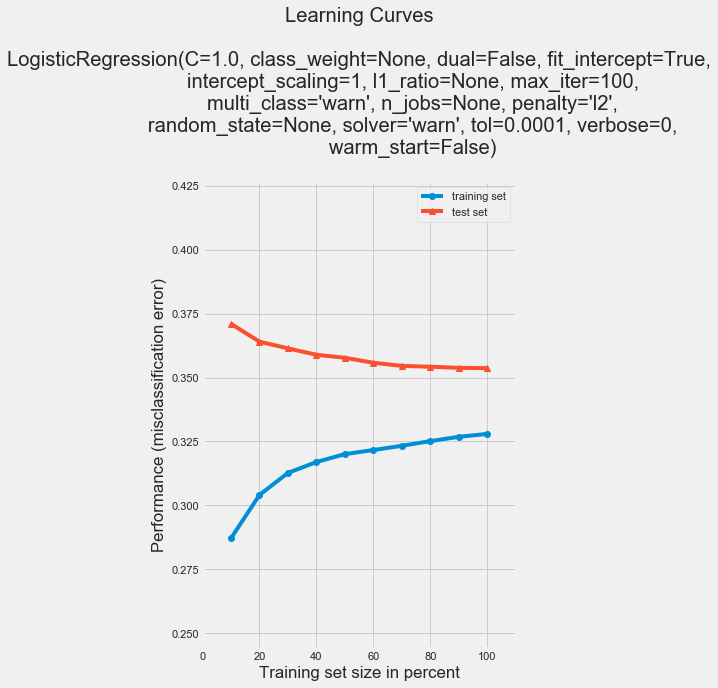

In [107]:
from mlxtend.plotting import plot_learning_curves

plot_learning_curves(cv_train, trainy, cv_val, valy,lr)

In [108]:
model = MLPClassifier(activation='relu',batch_size=32,random_state=9874,hidden_layer_sizes=(25,))
model.fit(cv_train,trainy)
print(model)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=9874, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [109]:
#Predicting the model for MLP on train
model_predict=model.predict(cv_train)
print(model_predict)

[3 3 3 ... 2 2 0]


In [110]:
print(classification_report(trainy.astype('int'),model_predict))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64     63673
           1       0.64      0.55      0.59     83472
           2       0.75      0.85      0.80    309467
           3       0.58      0.52      0.55    140987
           4       0.71      0.68      0.69    106440

    accuracy                           0.70    704039
   macro avg       0.67      0.64      0.66    704039
weighted avg       0.69      0.70      0.69    704039



In [111]:
model_val = model.predict(cv_val) #predict on val data
print(classification_report(valy.astype('int'),model_val))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62     27288
           1       0.62      0.54      0.58     35774
           2       0.75      0.84      0.79    132629
           3       0.56      0.50      0.53     60424
           4       0.70      0.67      0.68     45617

    accuracy                           0.69    301732
   macro avg       0.66      0.63      0.64    301732
weighted avg       0.68      0.69      0.68    301732



observations----accuracy has increased in MLP and f1 score also increased

## Concating pred columns on Both train and validation

In [113]:
concat = pd.concat([train_pred_index,val_pred_index])

In [114]:
concat

,pred
1004110,3
653512,2
771674,3
609233,2
644787,1
603464,3
603449,2
519873,4
62615,0
638838,4


In [115]:
sum_total = pd.merge(data_json1,concat,left_index=True, right_index=True)

In [116]:
sum_total.head(3)

,sentiment_score,stocktwit_tweet,ticker,time,date,Word Count,Character Count,Label,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment,pred
0,3,going up hesitating chart stable going upward,$AMD,18:38:28,2018-09-19,13,74,1,-0.0516,0.521,0.25,0.229,Negative,4
1,3,despite china trade war held,$CAT,03:51:06,2018-10-09,11,69,1,0.4847,0.560,0.00,0.440,Positive,3
2,2,wtf,$AVGO,13:35:32,2018-07-12,2,10,1,-0.5859,0.000,1.00,0.000,Negative,2


Droping Unwanted columns

In [117]:
sum_total.drop(['Word Count','Character Count','Label'], inplace = True,axis = 1) 

In [118]:
sum_total.drop(['Polarity Score','Neutral Score','Negative Score','Positive Score','Sentiment'], inplace = True,axis = 1) 

In [119]:
sum_total.head(2)

,sentiment_score,stocktwit_tweet,ticker,time,date,pred
0,3,going up hesitating chart stable going upward,$AMD,18:38:28,2018-09-19,4
1,3,despite china trade war held,$CAT,03:51:06,2018-10-09,3


# Importing the Test json

I am repeating same pre-processing steps to json Test data

In [120]:
with open('test_data.json') as f:
    a=json.load(f)

In [121]:
data_json2= json_normalize(a['records'])

In [122]:
data_json2.head()

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00


In [123]:
data_json2.dtypes

stocktwit_tweet    object
ticker             object
timestamp          object
dtype: object

In [124]:
#Creating datetime object 
data_json2['timestamp']=pd.to_datetime(data_json2['timestamp'],format='%Y-%m-%d %H:%M:%S')
data_json2.dtypes

stocktwit_tweet                 object
ticker                          object
timestamp          datetime64[ns, UTC]
dtype: object

In [125]:
data_json2['time']=data_json2['timestamp'].apply(lambda x:x.time)
data_json2['date']=data_json2['timestamp'].apply(lambda x:x.date)

In [126]:
data_json2.drop(['timestamp'],axis=1,inplace = True)

In [127]:
data_json2.head()

,stocktwit_tweet,ticker,time,date
0,$CELG nothing to be exited about,$CELG,14:26:16,2018-10-25
1,$AMD yall exhaust your buyer on first green ca...,$AMD,13:50:39,2018-07-13
2,$AMD day traders day.,$AMD,19:10:54,2018-09-25
3,$CBS https://tenor.com/wLB8.gif,$CBS,22:45:48,2018-07-27
4,$MU weak price action so far today. Don’t be a...,$MU,14:59:06,2018-07-31


In [128]:
# Missing Values
print("Missing Values: {}".format(data_json2.isnull().sum().sum()))

Missing Values: 0


In [129]:
# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*data_json2.shape)) #for indexing we are useing '*'

Dataframe Dimension: 265022 Rows, 4 Columns


In [131]:
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].replace('\#\w+', ' ',regex=True).astype(object)

In [132]:
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].replace('\@\w+', ' ',regex=True).astype(object)

In [133]:
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].replace('\$\w+', ' ',regex=True).astype(object)

In [134]:
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].replace('[\d]', ' ',regex=True).astype(object)

In [135]:
data_json2['stocktwit_tweet'] = data_json2['stocktwit_tweet'].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)

In [136]:
#Apply function on  stocktwit_tweet column
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].apply(strip_html)

In [137]:
#Apply function on  stocktwit_tweet column
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].apply(remove_between_square_brackets)

In [138]:
#Apply function on review column
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].apply(remove_special_characters)

In [139]:
data_json2['stocktwit_tweet'] = data_json2['stocktwit_tweet'].apply(punctuation_removal)
data_json2['stocktwit_tweet'].head()

0                           nothing to be exited about
1      yall exhaust your buyer on first green candl...
2                                      day traders day
3                                 httpstenorcomwLB gif
4      weak price action so far today Don t be afra...
Name: stocktwit_tweet, dtype: object

In [140]:
data_json2['stocktwit_tweet']=data_json2['stocktwit_tweet'].replace('\s+', ' ',regex=True).astype(object)

In [141]:
data_json2['stocktwit_tweet'].head(5)

0                           nothing to be exited about
1     yall exhaust your buyer on first green candle...
2                                      day traders day
3                                 httpstenorcomwLB gif
4     weak price action so far today Don t be afrai...
Name: stocktwit_tweet, dtype: object

# Spacy stop_words for Json test data

In [142]:
stop = stopword_list.Defaults.stop_words

In [143]:
len(stop)

322

Hear we are not adding or removing any stopwords like in json train.Because....

In [144]:
def stopwords_removal(stop_str):
    stop_str = word_tokenize(stop_str)
    return " ".join([word.lower() for word in stop_str 
            if word.lower() not in stop])

In [145]:
data_json2['stocktwit_tweet'] = data_json2['stocktwit_tweet'].apply(stopwords_removal)
data_json2['stocktwit_tweet'].head()

0                                               exited
1             yall exhaust buyer green candle byeeeeee
2                                      day traders day
3                                 httpstenorcomwlb gif
4    weak price action far today don t afraid short...
Name: stocktwit_tweet, dtype: object

# lemmatizer

In [146]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [147]:
data_json2["stocktwit_tweet"] = data_json2["stocktwit_tweet"].apply(lambda text: lemmatize_words(text))

In [148]:
Total = data_json2['stocktwit_tweet']
Total.head()

0                                               exited
1             yall exhaust buyer green candle byeeeeee
2                                       day trader day
3                                 httpstenorcomwlb gif
4    weak price action far today don t afraid short...
Name: stocktwit_tweet, dtype: object

# TF-IDF

In [149]:
#test_pred = tf_idf_vectorizer.transform(Total)

In [150]:
#test_pred

In [151]:
#pred1 = nb_clf.predict(test_pred)
#pred1

# Count vectorizer for json test data

In [152]:
test_pred = cv.transform(Total)
test_pred

<265022x61579 sparse matrix of type '<class 'numpy.int64'>'
	with 1539031 stored elements in Compressed Sparse Row format>

In [153]:
pred1 = lr.predict(test_pred)

In [154]:
pred1

array([2, 4, 2, ..., 2, 2, 4], dtype=int64)

# Creating the Predction column

In [155]:
predction = ['pred1']

In [156]:
data_json2['predction'] = pred1

In [157]:
data_json2.head()

,stocktwit_tweet,ticker,time,date,predction
0,exited,$CELG,14:26:16,2018-10-25,2
1,yall exhaust buyer green candle byeeeeee,$AMD,13:50:39,2018-07-13,4
2,day trader day,$AMD,19:10:54,2018-09-25,2
3,httpstenorcomwlb gif,$CBS,22:45:48,2018-07-27,2
4,weak price action far today don t afraid short...,$MU,14:59:06,2018-07-31,0


# Train CSV 
## pre-processing

In [158]:
train_data =pd.read_csv("train_factors-PHD.csv")

In [159]:
# Boolean for Positive and Negative Reviews
train_data["Label"] = 0
data_json1.loc[data_json1.sentiment_score >= 2,["Label"]] = 1

In [160]:
train_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Label
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,0
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,0
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,0
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,0
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0


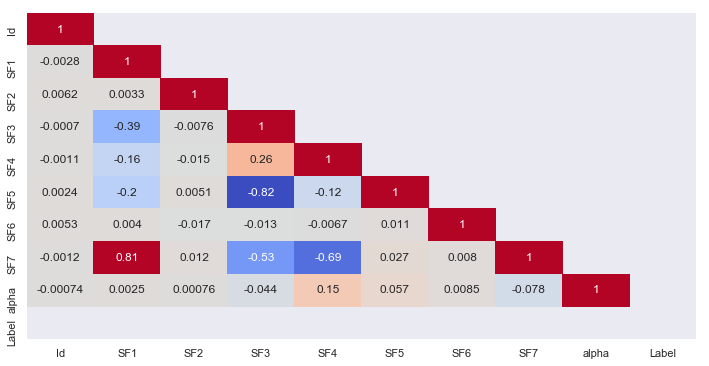

In [161]:
matrix = train_data.corr()
f, ax = plt.subplots(figsize=(12, 6))
with sns.axes_style("white"):
    sns.heatmap(matrix,mask=np.triu(matrix,1),annot=True, vmax=.8,cbar=False,cmap="coolwarm");


Looking at the correlation map we can see that SF1 is the most important feature for SF7.

Target varible is 'alpha'

In [162]:
train_data['alpha'].value_counts()

2    10912
3     5536
1     5467
4     5091
Name: alpha, dtype: int64

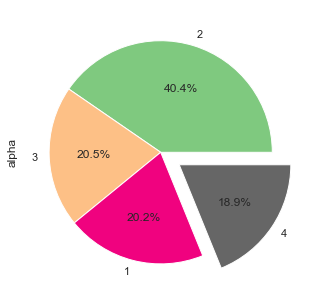

In [163]:
train_data['alpha'].value_counts().plot.pie(cmap="Accent",autopct="%1.1f%%",explode=[0,0,0,0.2])

More than 40% alpha values are 2's and remaning 60% are 1's,2's,4's are 18%

In [164]:
from scipy import stats

Skewness: -0.05353725967252619


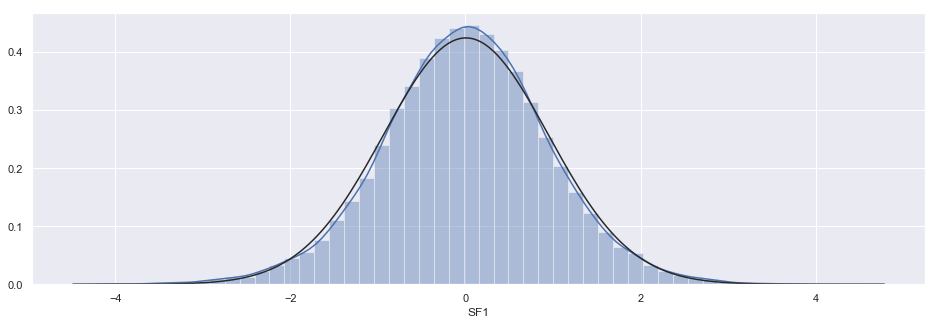

In [165]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF1'].skew())
sns.distplot(train_data['SF1'],fit = stats.norm)

Skewness: 0.028295274060124227


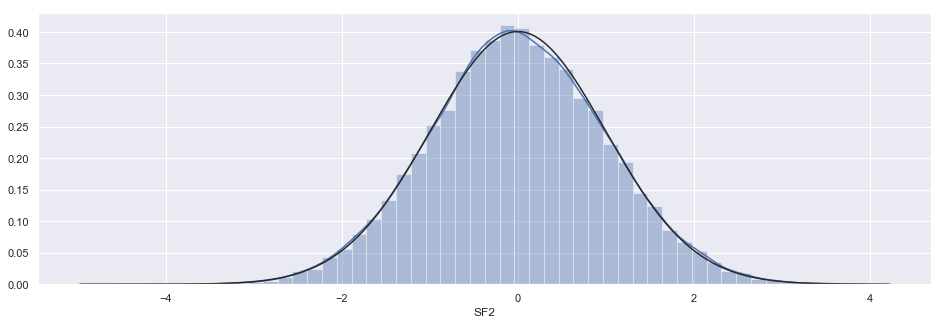

In [166]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF2'].skew())
sns.distplot(train_data['SF2'],fit = stats.norm)

Skewness: 0.1539585696572461


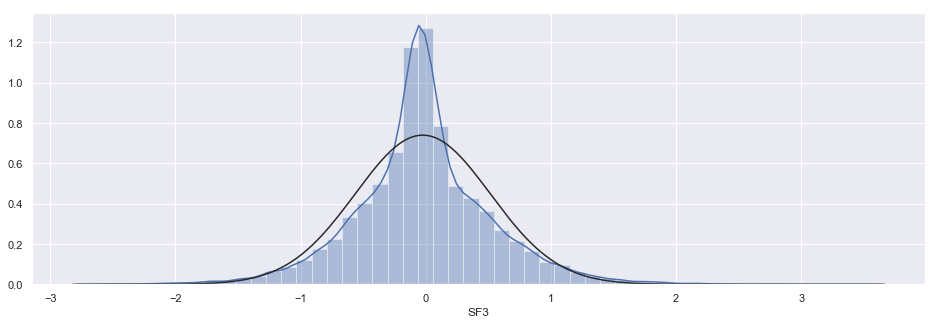

In [167]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF3'].skew())
sns.distplot(train_data['SF3'],fit = stats.norm)

Skewness: 0.032855466525139806


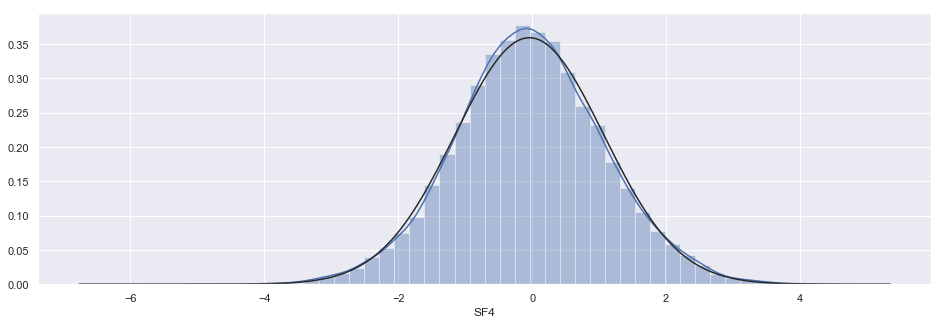

In [229]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF4'].skew())
sns.distplot(train_data['SF4'],fit = stats.norm)

Skewness: -0.14151466956761274


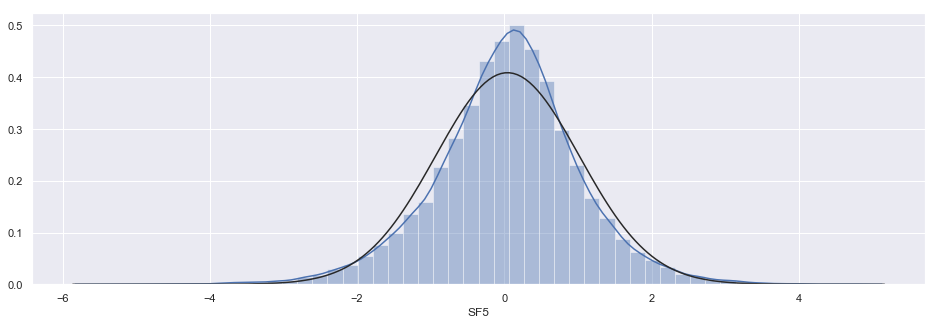

In [169]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF5'].skew())
sns.distplot(train_data['SF5'],fit = stats.norm)

Skewness: 0.008899200380558449


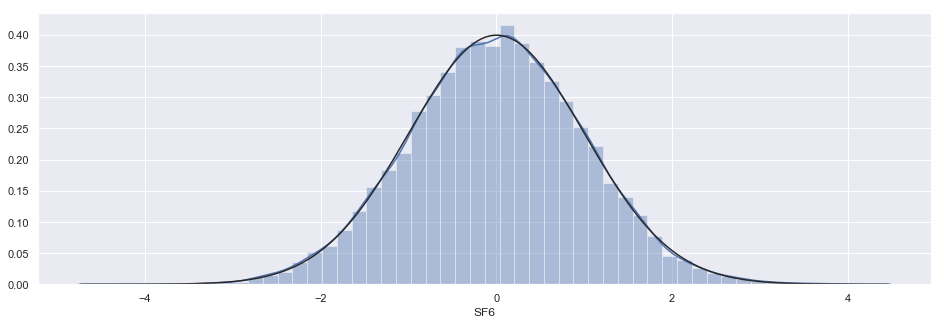

In [170]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF6'].skew())
sns.distplot(train_data['SF6'],fit = stats.norm)

Skewness: -0.1993963644649288


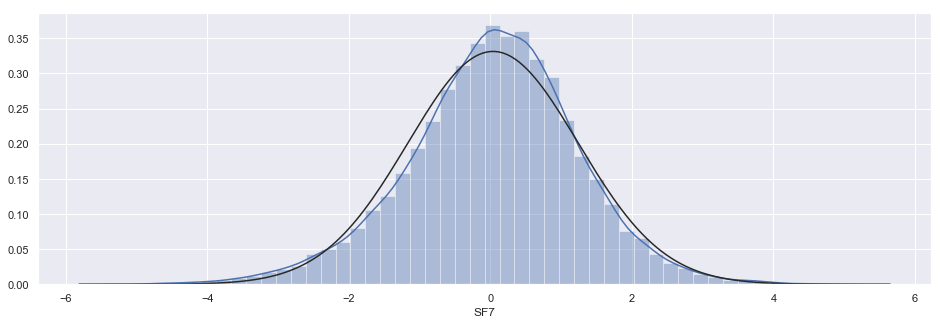

In [171]:
plt.figure(1,figsize=(16,5))
print("Skewness:",train_data['SF7'].skew())
sns.distplot(train_data['SF7'],fit = stats.norm)

In [172]:
train_data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
alpha       int64
Label       int64
dtype: object

In [173]:
print('json date',sum_total['date'].head(2)) 

json date 0    2018-09-19
1    2018-10-09
Name: date, dtype: object


In [174]:
print('train date',train_data['date'].head(2))

train date 0    21/08/18
1    11/10/18
Name: date, dtype: object


If we Observe json and train csv date formats are differnt. Bring them in to same format

In [175]:
train_data['date'] = train_data['date'].apply(lambda x: '20'+x.split('/')[-1]+'-'+x.split('/')[1]+'-'+x.split('/')[0])
train_data['date']=pd.to_datetime(train_data['date']).dt.date
sum_total['date']=pd.to_datetime(sum_total['date']).dt.date

In [176]:
sum_total['date'].head(2)

0    2018-09-19
1    2018-10-09
Name: date, dtype: object

In [177]:
train_data['date'].head(2)

0    2018-08-21
1    2018-10-11
Name: date, dtype: object

Now we converted in to same format. By doing this marging data sets should be easy

Removing $ symbol from Ticker

In [178]:
train_data['ticker']=train_data['ticker'].replace('\$', '',regex=True).astype(object)

In [179]:
sum_total['ticker'] = sum_total['ticker'].replace('\$', '',regex=True).astype(object)

In [180]:
train_data['ticker'].head(2)

0    NTAP
1    WYNN
Name: ticker, dtype: object

In [181]:
sum_total['ticker'].head(2)

0    AMD
1    CAT
Name: ticker, dtype: object

Converting them into lower case

In [182]:
train_data['ticker'].str.lower()

0        ntap
1        wynn
2         dri
3          ge
4          fe
5           f
6         low
7        ilmn
8         cmg
9         nee
10        len
11        ftr
12        tif
13       cost
14       lrcx
15         oi
16       dltr
17         vz
18       cboe
19       cdns
20        myl
21       wynn
22        big
23        dnr
24       amzn
25        syk
26        dal
27         ba
28        phm
29         mo
         ... 
26976     chd
26977     low
26978    amat
26979    shld
26980     kmx
26981    tgna
26982    sbac
26983      do
26984     slb
26985     jnj
26986     dnr
26987     vtr
26988    orly
26989    nvda
26990       x
26991     peg
26992     blk
26993     amp
26994       v
26995       v
26996    amzn
26997     key
26998      ea
26999     pxd
27000    tmus
27001      rf
27002      pg
27003     jcp
27004    nvda
27005     wba
Name: ticker, Length: 27006, dtype: object

In [183]:
sum_total['ticker'].str.lower()

0           amd
1           cat
2          avgo
3            ph
4            fb
5            fb
6           aet
7           noc
8          amzn
9           amd
10         nflx
11          gww
12         nflx
15          nwl
16          amd
17           mu
18           mu
19           mu
20           mu
21          eix
22           mu
23         amzn
24         nflx
25         msft
26         amzn
27           mu
28           ge
29           ge
30          uri
31         nflx
           ... 
1039098    abbv
1039099      mu
1039100      ge
1039101     utx
1039102     jpm
1039103     dis
1039104      ba
1039106      fb
1039107     clf
1039108     amd
1039109     amd
1039110     chk
1039111      mu
1039112    nvda
1039113    celg
1039114      mo
1039115      dg
1039116    isrg
1039117     chk
1039118     amd
1039119    amzn
1039120    msft
1039121     amd
1039122     pru
1039123     amd
1039124    aapl
1039125     amd
1039128      fb
1039129     amd
1039130    amzn
Name: ticker, Length: 10

# Groupby 

In [184]:
Lot_of=sum_total[['date','ticker','pred']].groupby(['date','ticker']).mean()

In [185]:
Lot_of.reset_index(level=['date', 'ticker'],inplace=True)

In [186]:
Lot_of.head()

,date,ticker,pred
0,2018-07-01,AABA,2.000000
1,2018-07-01,AAL,2.600000
2,2018-07-01,AAP,1.000000
3,2018-07-01,AAPL,2.162162
4,2018-07-01,ABBV,1.666667


## Marging of Two datasets 'Lot_of','train_data'

In [187]:
sum_total_train = pd.merge(train_data,Lot_of,how = 'left',left_on = ['date','ticker'],right_on = ['date','ticker'])

In [188]:
sum_total_train.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Label,pred
0,1,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,0,2.000000
1,2,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,0,2.000000
2,3,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,0,1.666667
3,4,2018-07-10,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,0,2.000000
4,5,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0,0.000000


Droping unwanted columns

In [189]:
sum_total_train.drop(['date'],axis=1,inplace= True)
sum_total_train.drop(['ticker'],axis=1,inplace= True)
sum_total_train.drop(['Id'],axis=1,inplace= True)

In [190]:
sum_total_train.isnull().sum()

SF1         0
SF2         0
SF3         0
SF4         0
SF5         0
SF6         0
SF7         0
alpha       0
Label       0
pred     2704
dtype: int64

In [191]:
from sklearn.impute import SimpleImputer

In [192]:
sum_total_train['pred'].fillna(sum_total_train['pred'].mean(),inplace = True)

Splitting the data

In [193]:
X = sum_total_train.drop(columns=['alpha'],axis=1)
y = sum_total_train['alpha']

In [194]:
train_x,val_x,train_y,val_y = split(X,y,test_size=0.3,random_state=1)
print('sum_total_train',sum_total_train.shape)
print('train_x',train_x.shape)
print('val_x',val_x.shape)

sum_total_train (27006, 10)
train_x (18904, 9)
val_x (8102, 9)


In [195]:
train_x.head(2)

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Label,pred
4124,-0.325594,0.534377,-0.222709,0.966916,0.697487,-0.274297,-0.801253,0,2.0
16402,-1.391800,-0.053202,0.104923,2.265053,0.810146,-2.623376,-2.595481,0,2.5


In [196]:
train_y.head(2)

4124     1
16402    2
Name: alpha, dtype: int64

In [197]:
train_x.isnull().sum()

SF1      0
SF2      0
SF3      0
SF4      0
SF5      0
SF6      0
SF7      0
Label    0
pred     0
dtype: int64

In [198]:
val_x.isnull().sum()

SF1      0
SF2      0
SF3      0
SF4      0
SF5      0
SF6      0
SF7      0
Label    0
pred     0
dtype: int64

In [199]:
sum_total_train.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Label,pred
0,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,0,2.000000
1,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,0,2.000000
2,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,0,1.666667
3,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,0,2.000000
4,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0,0.000000


In [200]:
model = MLPClassifier(activation='relu',batch_size=32,random_state=9874,hidden_layer_sizes=(25,))
model.fit(train_x, train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size=32, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(25,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=9874, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [201]:
sklearn_mlp_train_preds = model.predict(train_x)
sklearn_mlp_validation_preds = model.predict(val_x)

In [202]:
print(classification_report(train_y,sklearn_mlp_train_preds))

              precision    recall  f1-score   support

           1       0.70      0.58      0.63      3801
           2       0.83      0.98      0.90      7705
           3       0.65      0.56      0.60      3853
           4       0.73      0.69      0.71      3545

    accuracy                           0.76     18904
   macro avg       0.73      0.70      0.71     18904
weighted avg       0.75      0.76      0.75     18904



In [203]:
print(classification_report(val_y,sklearn_mlp_validation_preds))

              precision    recall  f1-score   support

           1       0.69      0.55      0.61      1666
           2       0.81      0.98      0.89      3207
           3       0.63      0.54      0.58      1683
           4       0.71      0.69      0.70      1546

    accuracy                           0.74      8102
   macro avg       0.71      0.69      0.70      8102
weighted avg       0.73      0.74      0.73      8102



# Test csv

## pre-processing

In [204]:
test_data =pd.read_csv("test_factors.csv")

In [205]:
test_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,24/10/18,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,27/07/18,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [206]:
test_data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
dtype: object

In [207]:
test_data['date'] = test_data['date'].apply(lambda x: '20'+x.split('/')[-1]+'-'+x.split('/')[1]+'-'+x.split('/')[0])
test_data['date']=pd.to_datetime(test_data['date']).dt.date

In [208]:
test_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,2018-10-05,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,2018-10-01,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,2018-10-24,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,2018-07-27,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [209]:
test_data['ticker']=test_data['ticker'].replace('\$', '',regex=True).astype(object)

In [210]:
data_json2['ticker']=data_json2['ticker'].replace('\$', '',regex=True).astype(object)

In [211]:
test_data['ticker'].head()

0    INTC
1    CTSH
2      CB
3    CTAS
4    intc
Name: ticker, dtype: object

In [212]:
data_json2['ticker'].head()

0    CELG
1     AMD
2     AMD
3     CBS
4      MU
Name: ticker, dtype: object

In [213]:
test_data['ticker'].str.lower()

0         intc
1         ctsh
2           cb
3         ctas
4         intc
5          tsn
6          nue
7        googl
8          spy
9          bdx
10         pkg
11        kors
12         agn
13         udr
14        navi
15        nflx
16        qcom
17         kss
18          wy
19         acn
20          an
21         etr
22         lmt
23         iff
24         dnr
25         wat
26         utx
27          ba
28        tsco
29         mcd
         ...  
11545      exc
11546      cvs
11547      uhs
11548     ulta
11549      vfc
11550      mnk
11551       ea
11552      stz
11553     tsco
11554     incy
11555     orcl
11556      nwl
11557      dis
11558     ffiv
11559      wdc
11560     adsk
11561      bax
11562      unp
11563      aep
11564      gis
11565       fb
11566      pnr
11567     shld
11568      psa
11569      anf
11570        t
11571      wfc
11572      mat
11573       rf
11574     bbby
Name: ticker, Length: 11575, dtype: object

In [214]:
data_json2['ticker'].str.lower()

0          celg
1           amd
2           amd
3           cbs
4            mu
5          amzn
6           clf
7            mu
8           amd
9           amd
10          amd
11          syf
12           fb
13          nke
14         alxn
15          amd
16         avgo
17         aapl
18         nflx
19          stz
20          adi
21          uaa
22        googl
23         amzn
24            f
25           mu
26         gild
27         fast
28         nflx
29          amd
          ...  
264992       fb
264993       mu
264994     msft
264995       fb
264996      nke
264997       fb
264998      gis
264999      crm
265000      mpc
265001      amd
265002      aap
265003       mu
265004      amd
265005       fb
265006      cat
265007     nflx
265008     vrtx
265009     aapl
265010       mu
265011     nflx
265012      nke
265013      mmm
265014     atvi
265015      stz
265016      avp
265017      cvs
265018        s
265019      amd
265020      tsn
265021     aapl
Name: ticker, Length: 26

In [215]:
Lot_of_csv=data_json2[['date','ticker','predction']].groupby(['date','ticker']).mean()

In [216]:
Lot_of_csv.reset_index(level=['date', 'ticker'],inplace=True)

In [217]:
Lot_of_csv.head()

,date,ticker,predction
0,2018-07-01,AAL,0.0
1,2018-07-01,AAPL,1.8
2,2018-07-01,AEP,2.0
3,2018-07-01,AES,3.0
4,2018-07-01,ALXN,0.0


In [218]:
sum_total_csv = pd.merge(test_data,Lot_of_csv,how = 'left',left_on = ['date','ticker'],right_on = ['date','ticker'])

In [219]:
sum_total_csv.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,predction
0,270007,2018-07-21,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,3.000000
1,270008,2018-10-05,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,3.000000
2,270009,2018-10-01,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,2.000000
3,270010,2018-10-24,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,2.500000
4,270011,2018-07-27,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,3.333333


In [220]:
#sum_total_csv.drop(['Id'],axis=1,inplace= True)

In [221]:
sum_total_csv.columns

Index(['Id', 'date', 'ticker', 'SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7',
       'predction'],
      dtype='object')

In [222]:
sum_total_csv.drop(['date'],axis=1,inplace= True)
sum_total_csv.drop(['ticker'],axis=1,inplace= True)

In [223]:
sum_total_csv.isnull().sum()

Id           0
SF1          0
SF2          0
SF3          0
SF4          0
SF5          0
SF6          0
SF7          0
predction    0
dtype: int64

In [224]:
y_prdiction = model.fit(train_x, train_y).predict(sum_total_csv)

In [225]:
y_prdiction

array([3, 3, 3, ..., 3, 3, 3], dtype=int64)

In [226]:
test_data =pd.read_csv("test_factors.csv")

In [227]:
Id = test_data[['Id']]
DT = test_data[['date']]

In [228]:
final_set = pd.DataFrame()
final_set = Id
final_set['alpha'] = pd.Series(y_prdiction)
final_set.to_csv('submission9.csv',index=False,sep=",")